In [24]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [25]:
df = pd.read_csv('creditcard.csv')[:80_000]
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [26]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values
f"Shapes of X={X.shape} y={y.shape}, Fraud Cases={y.sum()}"

'Shapes of X=(80000, 28) y=(80000,), Fraud Cases=196'

In [27]:
from sklearn.linear_model import LogisticRegression
# We can increase the weight of each class i.e for non fraud cases 0, we  assign a weight of 1 and for fraud cases 1, we give it double the weight, the idea is that we might have more fraud cases selected\
mod = LogisticRegression(class_weight={0: 1, 1:2}, max_iter=1000)
mod.fit(X, y).predict(X).sum()

171

## We can now find the best value for the class weight using grid search

In [28]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in range(1,4)]},
    cv=4,
    n_jobs=-1
)
grid.fit(X, y)

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]})

In [29]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,2.703079,0.467111,0.009674,0.000585,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.99405,0.99835,0.99945,0.99780,0.997413,0.002030,1
1,2.567236,0.616730,0.011410,0.003249,"{0: 1, 1: 2}","{'class_weight': {0: 1, 1: 2}}",0.99020,0.99840,0.99960,0.99805,0.996563,0.003718,2
2,1.919939,0.121488,0.004998,0.002119,"{0: 1, 1: 3}","{'class_weight': {0: 1, 1: 3}}",0.98730,0.99845,0.99960,0.99815,0.995875,0.004980,3


## The score comems from our model, we can have the LogisticRegression().score and with lr = LogisticRegression(); ??lr.score we can see the implementation of it

In [30]:
lr = LogisticRegression()
??lr.score

Signature: lr.score(X, y, sample_weight=None)
Source:   
    def score(self, X, y, sample_weight=None):
        """
        Return the mean accuracy on the given test data and labels.

        In multi-label classification, this is the subset accuracy
        which is a harsh metric since you require for each sample that
        each label set be correctly predicted.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test samples.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            True labels for `X`.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.

        Returns
        -------
        score : float
            Mean accuracy of ``self.predict(X)`` w.r.t. `y`.
        """
        from .metrics import accuracy_score

        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
File:      c:\users\user\appdata\local\programs\pyth

## We can see that it uses the accuracy_score unless we specify otherwise

In [31]:
from sklearn.metrics import precision_score, recall_score, make_scorer

## precision and recall both measure different things, what recall will tell us is that it will tell us did we get all the fraud cases and precision is saying: given that we predict fraud, how accurate are we

In [32]:
# precision_score(y, grid.predict(X))
recall_score(y, grid.predict(X))

0.5918367346938775

## Now, lets add precision and recall to the grid search: we have to tell the gridsearch to select the best model based on one of  the scores which is the refit property
### Higher cross validation would make our program take longer to run but it would have more accuracy when it comes out
### We can also use a numpy linear space with a dimension to increase the effect of the class weight. And by setting the class weight to a higher value, we are telling the algorithm to focus on the fraud cases

In [33]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)},
    refit='precision',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)
grid.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 14.758620689655173},
                                          {0: 1, 1: 15.413793103448276},
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827587},
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}]},
             refit='precision', return_train_score=True,
             scoring={'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [34]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split2_train_recall_score,split3_train_recall_score,split4_train_recall_score,split5_train_recall_score,split6_train_recall_score,split7_train_recall_score,split8_train_recall_score,split9_train_recall_score,mean_train_recall_score,std_train_recall_score
0,3.671474,0.410574,0.032869,0.025420,"{0: 1, 1: 1.0}","{'class_weight': {0: 1, 1: 1.0}}",1.000000,0.463415,0.583333,1.000000,...,0.627119,0.548023,0.573864,0.573864,0.562500,0.613636,0.636364,0.607955,0.612185,0.054733
1,3.114547,0.244071,0.023305,0.006509,"{0: 1, 1: 1.6551724137931034}","{'class_weight': {0: 1, 1: 1.6551724137931034}}",1.000000,0.463415,0.583333,1.000000,...,0.683616,0.627119,0.670455,0.647727,0.630682,0.687500,0.698864,0.687500,0.680239,0.050286
2,3.137518,0.413214,0.022142,0.004209,"{0: 1, 1: 2.310344827586207}","{'class_weight': {0: 1, 1: 2.310344827586207}}",1.000000,0.463415,0.583333,1.000000,...,0.740113,0.683616,0.710227,0.698864,0.687500,0.715909,0.744318,0.727273,0.724454,0.043881
3,3.415025,0.312025,0.028733,0.015296,"{0: 1, 1: 2.9655172413793105}","{'class_weight': {0: 1, 1: 2.9655172413793105}}",1.000000,0.452381,0.583333,1.000000,...,0.785311,0.706215,0.744318,0.732955,0.715909,0.755682,0.772727,0.738636,0.749978,0.039589
4,3.030541,0.470301,0.020457,0.003053,"{0: 1, 1: 3.6206896551724137}","{'class_weight': {0: 1, 1: 3.6206896551724137}}",1.000000,0.452381,0.583333,1.000000,...,0.824859,0.740113,0.755682,0.744318,0.727273,0.778409,0.784091,0.761364,0.771498,0.037959
5,3.163898,0.404780,0.021819,0.004870,"{0: 1, 1: 4.275862068965517}","{'class_weight': {0: 1, 1: 4.275862068965517}}",1.000000,0.452381,0.583333,1.000000,...,0.841808,0.768362,0.778409,0.789773,0.772727,0.789773,0.795455,0.772727,0.792485,0.029289
6,3.147438,0.188007,0.022594,0.004060,"{0: 1, 1: 4.931034482758621}","{'class_weight': {0: 1, 1: 4.931034482758621}}",1.000000,0.452381,0.583333,1.000000,...,0.847458,0.802260,0.789773,0.818182,0.801136,0.801136,0.818182,0.789773,0.812327,0.021063
7,2.925633,0.406611,0.020327,0.003530,"{0: 1, 1: 5.586206896551724}","{'class_weight': {0: 1, 1: 5.586206896551724}}",1.000000,0.452381,0.583333,1.000000,...,0.847458,0.813559,0.829545,0.829545,0.812500,0.806818,0.835227,0.818182,0.827080,0.017190
8,3.058873,0.328785,0.026412,0.016289,"{0: 1, 1: 6.241379310344827}","{'class_weight': {0: 1, 1: 6.241379310344827}}",0.944444,0.452381,0.583333,0.947368,...,0.847458,0.824859,0.846591,0.835227,0.823864,0.829545,0.857955,0.829545,0.838431,0.013974
9,3.148276,0.526671,0.020580,0.003165,"{0: 1, 1: 6.896551724137931}","{'class_weight': {0: 1, 1: 6.896551724137931}}",0.944444,0.452381,0.583333,0.947368,...,0.853107,0.830508,0.846591,0.835227,0.829545,0.835227,0.863636,0.846591,0.844665,0.012015


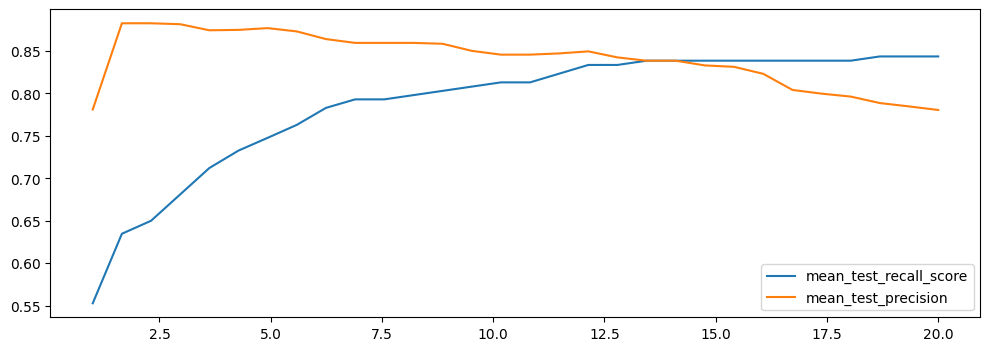

In [42]:
plt.figure(figsize=(12, 4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall_score', 'mean_test_precision']:
    plt.plot([_[1] for _ in df['param_class_weight']],
            df[score],
            label=score)
plt.legend()

In [41]:
df['mean_test_precision']

0     0.780937
1     0.882453
2     0.882453
3     0.881349
4     0.874206
5     0.874683
6     0.876749
7     0.872877
8     0.863844
9     0.859370
10    0.859370
11    0.859370
12    0.858318
13    0.850010
14    0.845536
15    0.845536
16    0.846986
17    0.849392
18    0.842286
19    0.838390
20    0.838390
21    0.832833
22    0.831183
23    0.822954
24    0.804012
25    0.799627
26    0.796181
27    0.788547
28    0.784599
29    0.780411
Name: mean_test_precision, dtype: float64